# Bolivia PEGS using SAC

- I recently reproduced the Tohoku PEGS signals from Vallee et al 2017...Now for the Bolivia earthquake: 

## Real data :
### Download

In [1]:
from obspy import read
import shutil
from obspy.clients.fdsn import Client as CLFDSN
from obspy.clients.iris import Client as CLIRIS
from obspy import UTCDateTime
import os 
import matplotlib.pyplot as plt
import fileinput
from datetime import datetime

download_data = True
real_data_dir = "./data_bolivia"



# Initialise data download clients
clientFDSN = CLFDSN("IRIS") # Client for downloading the mseed data
clientIRIS = CLIRIS()       # Client for downloading the resp data



# Event was at 00:33:16:40 on Jun 9th 1994
starttime = UTCDateTime("1994-6-8T23:30:00")
endtime   = UTCDateTime("1994-6-9T01:00:00")


stations = [['NNA',  'II', '*'],
            ['YUNZ', 'XE', '*'],
            ['LPAZ', 'GT', '*'],
           ]

chan = "BHZ"

if download_data: 
    
    # Clean out the directory: 
    if os.path.exists(real_data_dir):
        shutil.rmtree(real_data_dir)
    os.mkdir(real_data_dir)
    os.mkdir(f'./{real_data_dir}/out')
    os.mkdir(f'./{real_data_dir}/raw')


    for i in range(len(stations)):
        sta = stations[i][0]  # station code
        net = stations[i][1]  # network of the station
        loc = stations[i][2]
        outdir = real_data_dir
        prefix = f'{net}.{sta}.{loc}.{chan}'
        respprefix = f'{net}.{sta}.00.{chan}'

        respfname = f'{outdir}/RESP.{respprefix}'
        sacfname  = f'{outdir}/raw/{prefix}.sac'

        st = clientFDSN.get_waveforms(network=net, station=sta, channel=chan, location=loc, starttime=starttime, endtime=endtime)
        resp = clientIRIS.resp(network=net, station=sta, location=loc, channel=chan, 
                           starttime=starttime, endtime=endtime, filename=respfname)

        # Write sac file

        print(f'Written ', respfname)
        st.write(sacfname, format='SAC') 
        print(f'        ', sacfname)
    print('DONE!')


    # We need to remove one of the YUNZ channels as its not good - 
    os.remove(f"{real_data_dir}/raw/XE.YUNZ.*.BHZ01.sac")


Written  ./data_bolivia/RESP.II.NNA.00.BHZ
         ./data_bolivia/raw/II.NNA.*.BHZ.sac
Written  ./data_bolivia/RESP.XE.YUNZ.00.BHZ
         ./data_bolivia/raw/XE.YUNZ.*.BHZ.sac
Written  ./data_bolivia/RESP.GT.LPAZ.00.BHZ
         ./data_bolivia/raw/GT.LPAZ.*.BHZ.sac
DONE!


## SAC MACROS: 

Here I have manually decided on the arrival times (relative to the source time). For some reason I need to make separate macros for YUNZ and the other statiosn: 

### NNA/LPAZ macro with 2 pole highpass filter

In [18]:
# Arrival time picks 
T0 = {'NNA'  :135,
      'YUNZ' :104,
      'LPAZ' :80,
     }


macro_fname = f"{real_data_dir}/bolivia_sac_macro_2pole"
now = datetime.now()


# Check if 'macro' file exists and save it as a separate datestamped file if it does
if os.path.exists(macro_fname):
    os.rename(macro_fname, macro_fname + str(now))

    
#------------------------ Printing macro commands to file: ------------------------
f = open(macro_fname, "a")

f.write(f"* BOLIVIA MACRO CREATED by WE at {now} \n")
f.write(f"*****************************************************\n\n\n\n")
f.write(f"* --------------- loading the stations ---------------\n\n")

write_out_str = 'w '
f.write("* Load stations: \n")
i = 0
for stn_name in ['LPAZ', 'NNA']:
    if i == 0: 
        f.write(f"r      ./raw/*{stn_name}*.sac\n")
    else: 
        f.write(f"r more ./raw/*{stn_name}*.sac\n")
    write_out_str += f'./out/{stn_name}_proc.sac '
    i +=1

    
f.write(f"\n\n\n* --------------- change time parameters ---------------\n\n")

# Changing O and T1 times: 
f.write("\n* Change O time for all data to event time\n")   

# Set reference time by writing 0 marker and subtracting everything relative to this
# Event was on 160th Julian day
f.write("CHNHDR O GMT 1994 160 00 33 16 040\n\n")
f.write("chnhdr allt (0 - &1,o&) IZTYPE IO \n\n")

i = 0
for stn_name in ['LPAZ', 'NNA']:
    f.write(f"chnhdr file {str(int(i+1))} T0 {T0[stn_name]}\n")
    i += 1 
    

f.write(f"\n\n\n* -------- temporarily write out the files --------\n\n")

# Now write the files so that when they are reloaded they are loaded only up to their cut points: 
f.write("\n* Write files temporarily - will be reloaded\n")
f.write(write_out_str) 


f.write("\n* DELETE ALL FILES IN MEMORY: \n")
f.write("dc 1 2")

    
f.write("\n* Ensure traces are cut at pick\n")
f.write("cut b T0 \n\n")
    
    
f.write(f"\n\n\n* -------- reload temp files with correct time cuts --------\n\n")

f.write(f"* NOTE THAT YUNZ USES DIFFERENT Highpass FILTER \n * --> NNA and LPAZ use a 2 pole \
        highpass causal butterworth filter but YUNZ uses 4 poles so need to do this separately:")

f.write(f"* First lets loads the two that are the same: \n")
f.write(f"r      ./out/*NNA*.sac\n")
f.write(f"r more ./out/*LPAZ*.sac\n")

    
# Core processing steps:     
f.write(f"\n\n\n* -------- begin data processing for NNA/LPAZ --------\n\n")

f.write("\n* Remove the mean: \n")
f.write("rmean\n\n")

f.write("* Remove instrument response\n")
f.write("transfer from evalresp to acc freql 0.0001 0.0002 1 2\n\n")

f.write("* Lowpass filters:\n")
f.write("lowpass butter corner 0.03 npoles 6 passes 1\n\n")

f.write("* Resample to avoid aliasing\n")
f.write("interpolate delta 0.2\n\n")

f.write("* Highpass: \n")
f.write("highpass butter corner 0.002 npoles 2 passes 1\n\n")

f.write("* Write files\n")
f.write("w ./out/NNA_proc.sac ./out/LPAZ_proc.sac\n\n" )


f.close()



### YUNZ macro with 2 pole highpass filter

In [19]:

macro_fname = f"{real_data_dir}/bolivia_sac_macro_4pole"
now = datetime.now()


# Check if 'macro' file exists and save it as a separate datestamped file if it does
if os.path.exists(macro_fname):
    os.rename(macro_fname, macro_fname + str(now))

    
#------------------------ Printing macro commands to file: ------------------------
f = open(macro_fname, "a")

f.write(f"* YUNZ MACRO CREATED by WE at {now} \n")
f.write(f"*****************************************************\n\n\n\n")

write_out_str = 'w '
f.write("* Load stations: \n")
f.write("r more ./raw/*YUNZ*.sac \n")


    
f.write(f"\n\n\n* --------------- change time parameters ---------------\n\n")

# Changing O and T1 times: 
f.write("\n* Change O time for all data to event time\n")   

# Set reference time by writing 0 marker and subtracting everything relative to this
# Event was on 160th Julian day
f.write("CHNHDR O GMT 1994 160 00 33 16 040\n\n")
f.write("chnhdr allt (0 - &1,o&) IZTYPE IO \n\n")


f.write(f"chnhdr file 1 T0 {T0['YUNZ']}\n")


f.write(f"\n\n\n* -------- temporarily write out the files --------\n\n")

# Now write the files so that when they are reloaded they are loaded only up to their cut points: 
f.write("\n* Write files temporarily - will be reloaded\n")
f.write("w ./out/YUNZ_proc.sac\n") 


f.write("\n* DELETE ALL FILES IN MEMORY: \n")
f.write("dc 1")

    
f.write("\n* Ensure traces are cut at pick\n")
f.write("cut b T0 \n\n")
    
    
    
# Core processing steps:     
f.write(f"\n\n\n* -------- begin data processing for YUNZ --------\n\n")
f.write(f"r ./out/YUNZ_proc.sac\n")


f.write("\n* Remove the mean: \n")
f.write("rmean\n\n")

f.write("* Remove instrument response\n")
f.write("transfer from evalresp to acc freql 0.0001 0.0002 1 2\n\n")

f.write("* Lowpass filters:\n")
f.write("lowpass butter corner 0.03 npoles 6 passes 1\n\n")

f.write("* Resample to avoid aliasing\n")
f.write("interpolate delta 0.2\n\n")

f.write("* Highpass NOTE HERE THAT IT HAS 4 POLES: \n")
f.write("highpass butter corner 0.002 npoles 4 passes 1\n\n")

f.write("* Write files\n")
f.write("w ./out/YUNZ_proc.sac" )



f.close()

## Plot the real data

(-1.0, 5.0)

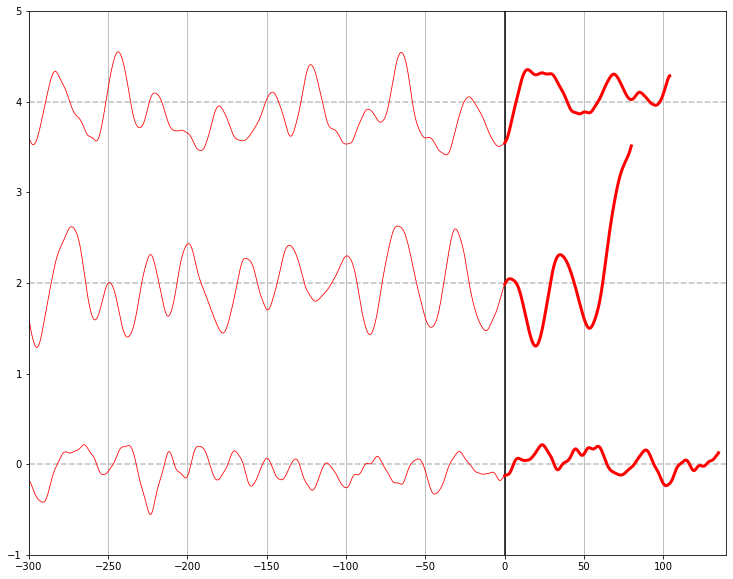

In [21]:
stations = ['NNA', 'LPAZ', 'YUNZ']


# Load processed data (SAC files)
from obspy.core.stream import Stream
import sys
import numpy as np 
sys.path.append('../')
from wetools import obspy_gen_mpl, normalise



st = Stream()
for i in range(len(stations)): 
    stn_name = stations[i]
    st += read(f'{real_data_dir}/out/{stn_name}_proc.sac')

# Timings: 
secs_before = 1800
secs_after  = 200
event_time  = UTCDateTime("1994-6-9T00:33:16")

st = st.slice(starttime=event_time - secs_before , endtime=event_time + secs_after)



fig, ax = plt.subplots(figsize=(12.5, 10))

ax.axvline(0, linestyle='-', color='k')
for i in range(len(stations)):
    tr = st.select(station=stations[i])[0]
    t,y = obspy_gen_mpl(tr)

    if stations[i] == 'YUNZ':
        # For some reason YUNZ requires conversion to nm/s^2
        y *= 1e9
    
    t = t - secs_before
    
    # Cutoff for any amplitude above 3 nm/s^2 
    #cutamp = 1.5
    
    #indx_t0 = np.where(t>=0)[0][0]
    #cutoff = indx_t0 + np.where(np.abs(y[indx_t0:])>cutamp)[0][0]
    
    #t = t[:cutoff]
    #y = y[:cutoff]
    
    #if np.max(y)>cutamp: 
    #    print(stations[i])
    cutamp = 2
    ax.axhline(i*cutamp, color='grey', linestyle='--', alpha=0.5)
    
    
    ax.plot(t[t<0], y[t<0] + i*cutamp, 'r', linewidth=0.8)
    ax.plot(t[t>0], y[t>0] + i*cutamp, 'r', linewidth=3)
    ax.grid

ax.set_xlim([-300, 140])
ax.xaxis.grid(True)
ax.set_ylim([-1, 5])


# Synthetic data